# Analyse campagnes marketing client
Dans ce Notebook, nous retrouverez l'ensemble des analyses exploratoires, modèles prédictifs et clusterings client effectués pour justifier notre chiffrage de
l’efficacité des campagnes marketing et cerner la cible client du magasin.

Pour faire fonctionner ce Notebook, nous devons au préalable importer certaines bibliothèques Python :

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime

from matplotlib import rcParams
from matplotlib.cbook import boxplot_stats
from datetime import date
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

Avant de pouvoir analyser notre jeu de données, nous devons d'abord le récupérer dans le fichier .csv "Camp_Market" :

In [70]:
df = pd.read_csv("Camp_Market.csv", sep=';')

## 1 - Nettoyage et organisation des données

Pour commencer, nous avons nettoyé les données pour comprendre leur structure et les informations qu'elles contiennent. Certaines colonnes de notre jeu de données contiennent des variables catégorielles, comme c'est le cas pour `Education`. Afin d'effectuer notre analyse exploratoire, nous avons besoin de convertir ces variables catégorielles en valeurs numériques.

Dans cette optique, nous avons restructuré notre jeu de données : grâce au One-Hot, nous avons pu convertir nos valeurs catégorielles en valeurs numériques dans le but de faciliter l'analyse.

In [71]:
# Encodage One-Hot
data_encoded = pd.get_dummies(df, columns=['Education'])

Nous avons ensuite créé huit nouvelles colonnes numériques contenant les nouvelles valeurs :

In [72]:
#var Living_with
def love_status(status):
    if status == "Single" or status == "Widow" or status == "Divorced":
        return 'Single'
    elif status == "Together" or status == "Married":
        return 'In a relationship'
data_encoded["Living_with"] = df["Marital_Status"].apply(love_status)

#var Family_size
data_encoded["Family_size"] = data_encoded["Kidhome"] + data_encoded["Teenhome"] + np.where(
    (data_encoded["Marital_Status"] == "Together") | (data_encoded["Marital_Status"] == "Married"), 
    2, 
    1
)

# var Customer_for nombre de jours depuis que le client a commencé ses achats au magasin depuis la dernière date enregistrée
today = pd.Timestamp(datetime.date.today())
data_encoded["Customer_for"] = (today - pd.to_datetime(df["Dt_Customer"])).dt.days

# var Age
data_encoded["Age"] = date.today().year - data_encoded["Year_Birth"]

#var Spend
data_encoded["Spent"] = data_encoded[[col for col in df.columns if col.startswith('Mnt')]].sum(axis=1)

#var Is_parent
data_encoded["Is_parent"] = np.where((data_encoded["Kidhome"] > 0) | (data_encoded["Teenhome"] > 0), 1, 0)

#var Children
data_encoded["Children"] = data_encoded.Kidhome + data_encoded.Teenhome

#var Education
def edu_level(level):
    if (level == "Master" or level == "Phd") :
        return 2
    elif(level == "Graduation") :
        return 1
    else :
        return 0

#var Marital_Status_Score
data_encoded["Marital_Status_Score"] = data_encoded["Marital_Status"].map({
    "Alone" :1,
    "Single": 2,
    "Together": 3,
    "Married": 4,
    "Divorced": 5,
    "Widow": 6,
})
data_encoded["Education2"] = df["Education"].apply(edu_level)

Maintenant que l'on a les colonnes qui nous intéressent, nous supprimons les colonnes contenant des valeurs vides et les colonnes non utilisées :

In [73]:
dropped_columns = ["Dt_Customer", "Dt_Customer", "Marital_Status", "Year_Birth", "Kidhome", "Teenhome", "Living_with", "Education_Master", "Education_PhD", "Education_Graduation", "Education_Basic", "Education_2n Cycle"]
data_encoded = data_encoded.drop(dropped_columns, axis=1)
data_encoded = data_encoded.dropna()
data_encoded.head()

,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,Z_Revenue,Response,Family_size,Customer_for,Age,Spent,Is_parent,Children,Marital_Status_Score,Education2
0,5524,58138.0,58,635,88,546,172,88,88,3,...,11,1,1,4054,66,1617,0,0,2.0,1
1,2174,46344.0,38,11,1,6,2,1,6,2,...,11,0,3,3504,69,27,1,2,2.0,1
2,4141,71613.0,26,426,49,127,111,21,42,1,...,11,0,2,3703,58,776,0,0,3.0,1
3,6182,26646.0,26,11,4,20,10,3,5,2,...,11,0,3,3530,39,53,1,1,3.0,1
4,5324,58293.0,94,173,43,118,46,27,15,5,...,11,0,3,3552,42,422,1,1,4.0,0


Enfin, on observe la répartition des données de chaque colonne autour de leurs médianes respectives afin de déterminer les valeurs aberrantes :

Text(0.5, 1.0, 'Graphique de répartition des valeurs par colonne')

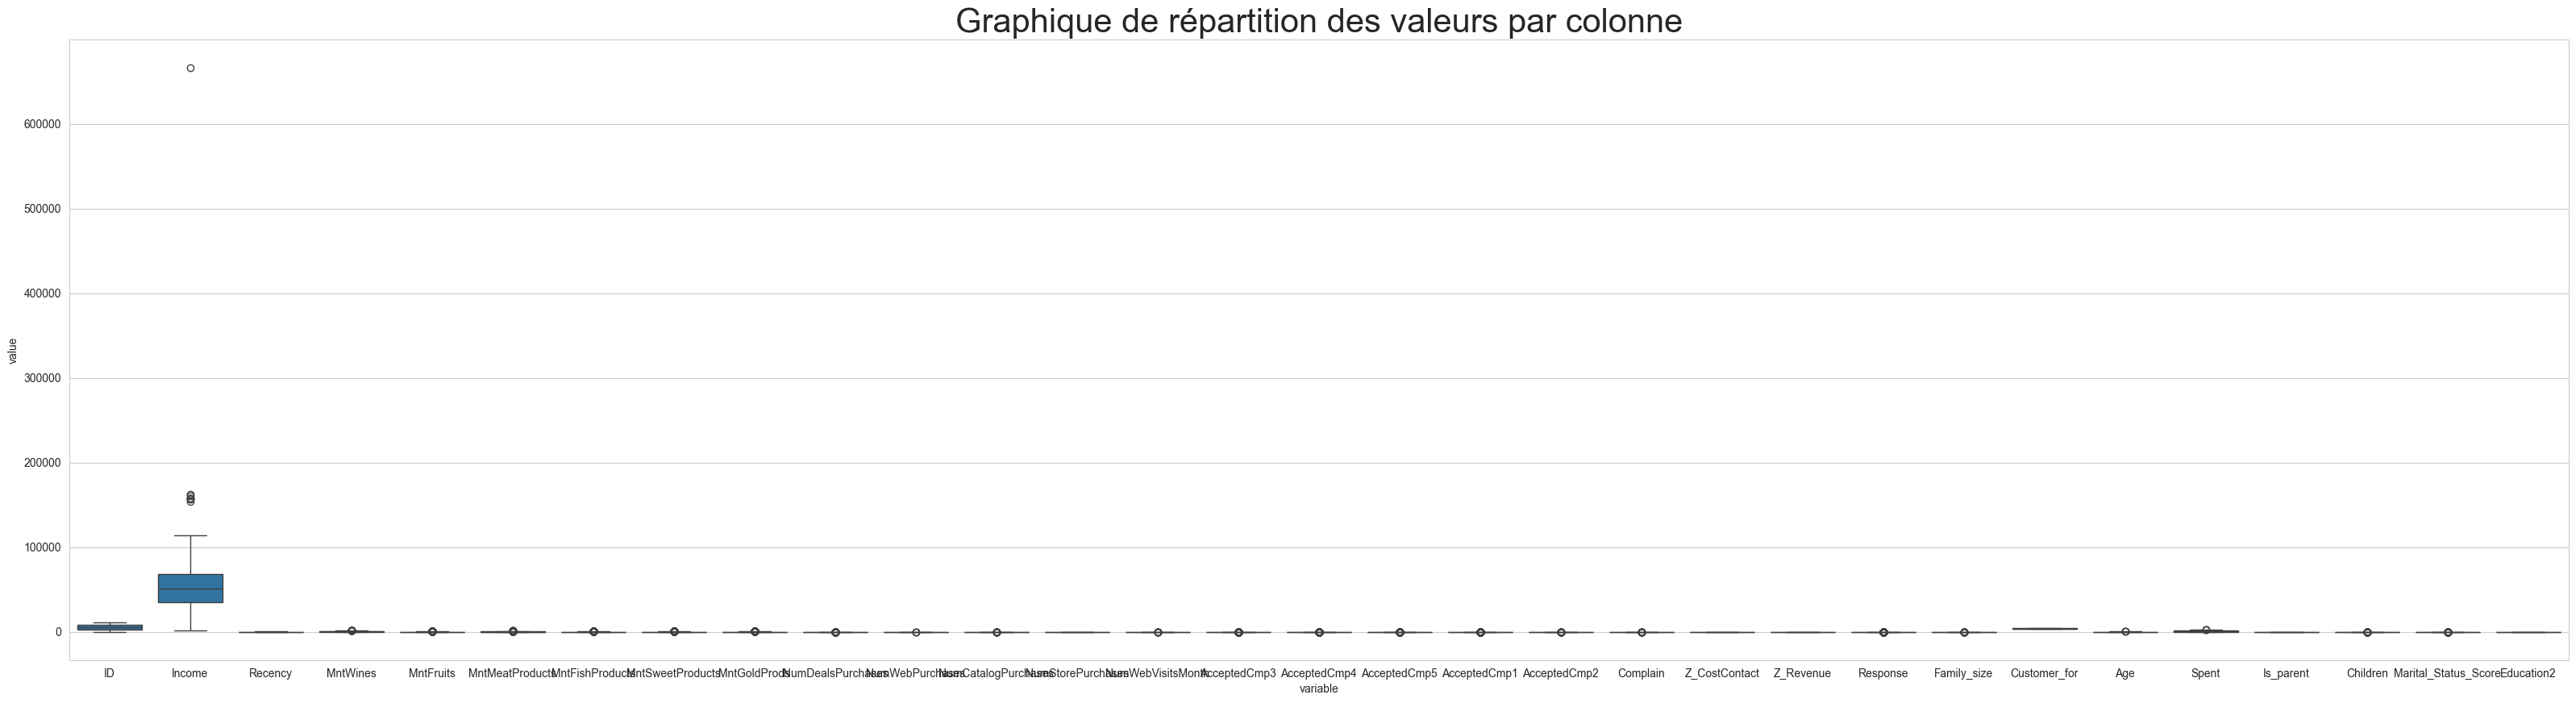

In [74]:
sns.boxplot(x='variable', y='value', data=pd.melt(data_encoded))
plt.title("Graphique de répartition des valeurs par colonne", fontsize=30)

Après observation des graphiques en boîte à moustaches, la catégorie `Income` (revenus) possède les valeurs aberrantes les plus prononcées. On observe aussi que la plupart des colonnes possèdent des valeurs aberrantes dans le jeu : 

Text(0.5, 1.0, "Graphique de répartition des valeurs par colonne sans 'Income'")

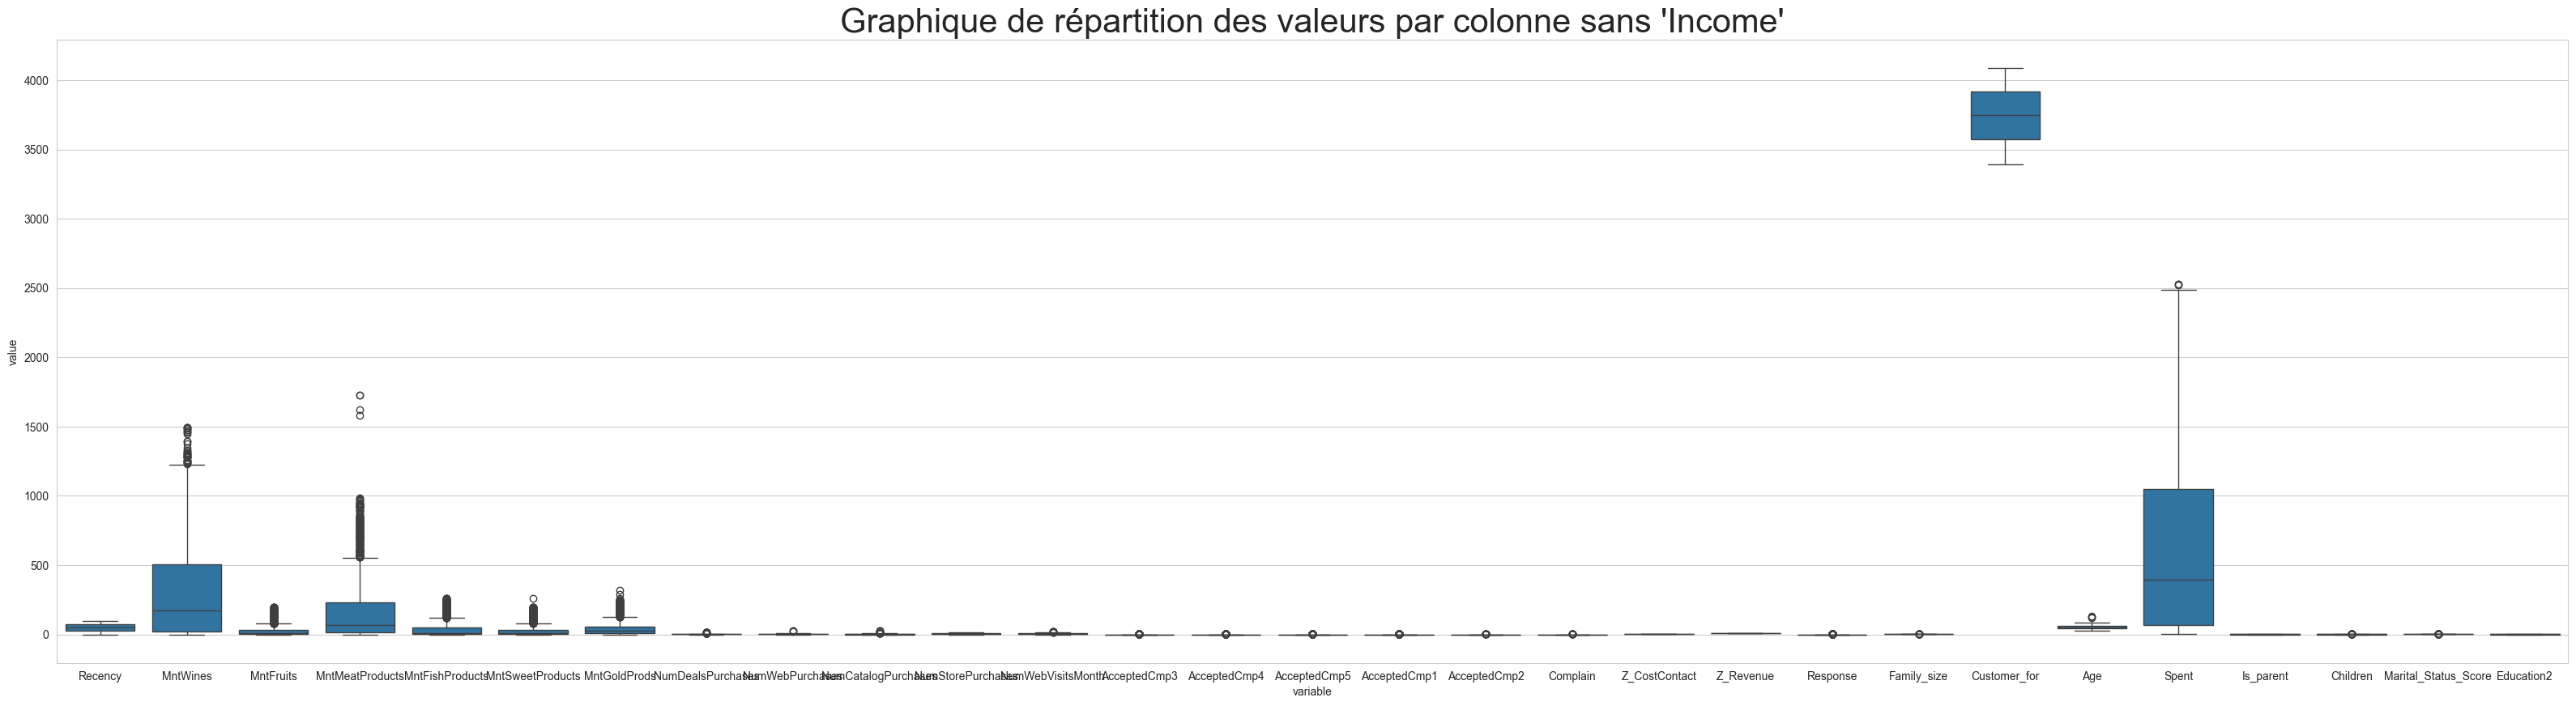

In [75]:
# Code
rcParams['figure.figsize'] = 40, 10
sns.boxplot(x='variable', y='value', data=pd.melt(data_encoded.drop(columns=["Income", "ID"])))
plt.title("Graphique de répartition des valeurs par colonne sans 'Income'", fontsize=30)

Cependant, seules les valeurs de la catégorie `Income` sont assez significatives pour réellement influencer les résultats d'analyse. Nous avons donc récupéré ces valeurs, afin de les exclure par la suite de notre jeu de données : 

Text(0.5, 1.0, 'Graphique de répartition des valeurs par colonne sans valeurs aberrantes')

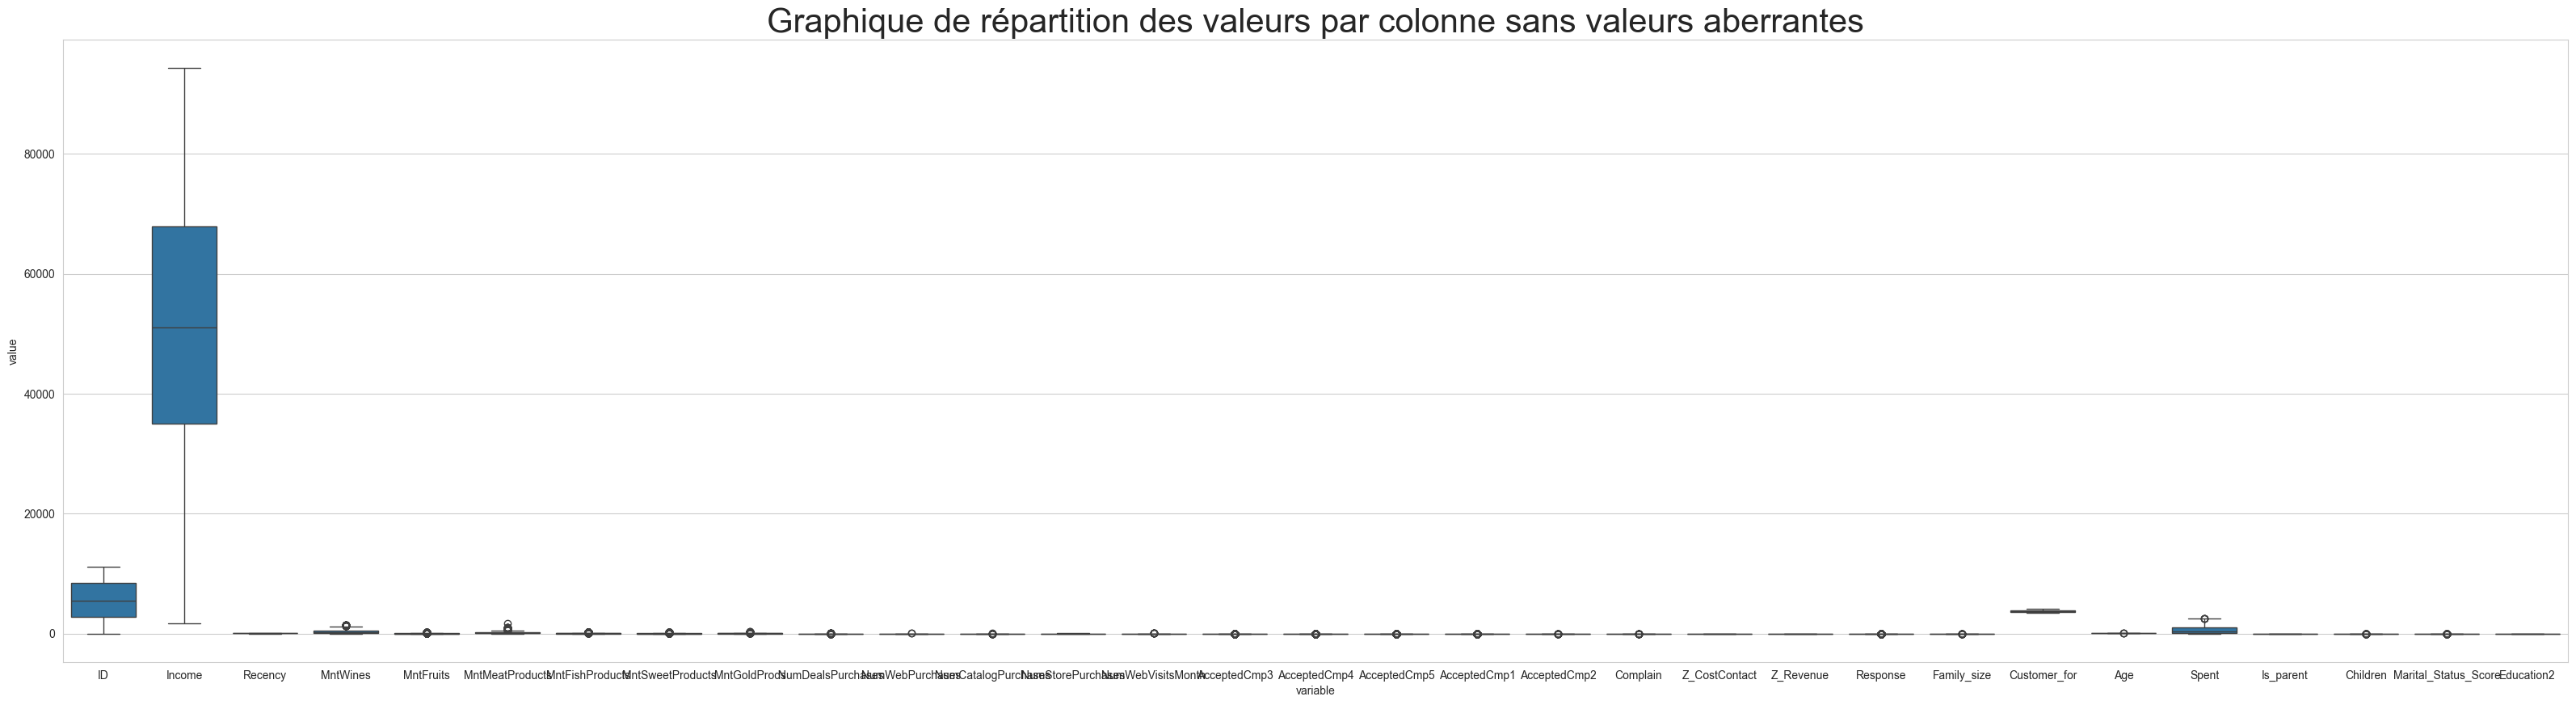

In [76]:
# Code
q_hi  = df["Income"].quantile(0.99)

data_encoded = data_encoded[data_encoded["Income"] < q_hi]
sns.boxplot(x='variable', y='value', data=pd.melt(data_encoded))
plt.title("Graphique de répartition des valeurs par colonne sans valeurs aberrantes", fontsize=30)

Pour finir ce nettoyage, nous devons gérer le cas des valeurs constantes ainsi que non présentes.

En outre, 1.07% des valeurs de la colonne `Income` a des valeurs manquantes. Étant donné que ce pourcentage est assez faible, nous avons choisi de supprimer ces lignes. De plus, les colonnes `Z_CostContact` et `Z_Revenue` sont constantes, ce qui veut dire qu'elles possèdent la même valeur pour tous les clients. Elles ne seront donc pas utiles pour notre analyse et ont été supprimées :

In [77]:
# Code
data_encoded = data_encoded.drop(columns=["Z_CostContact", "Z_Revenue"]);
data_encoded.head()

,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,Complain,Response,Family_size,Customer_for,Age,Spent,Is_parent,Children,Marital_Status_Score,Education2
0,5524,58138.0,58,635,88,546,172,88,88,3,...,0,1,1,4054,66,1617,0,0,2.0,1
1,2174,46344.0,38,11,1,6,2,1,6,2,...,0,0,3,3504,69,27,1,2,2.0,1
2,4141,71613.0,26,426,49,127,111,21,42,1,...,0,0,2,3703,58,776,0,0,3.0,1
3,6182,26646.0,26,11,4,20,10,3,5,2,...,0,0,3,3530,39,53,1,1,3.0,1
4,5324,58293.0,94,173,43,118,46,27,15,5,...,0,0,3,3552,42,422,1,1,4.0,0


## 2 - Analyse Exploratoire

Maintenant que nos données sont nettoyées, nous avons exploré les données pour comprendre leur structure, détecter des valeurs manquantes afin de produire des outils de visualisation des distributions des différentes variables.

### A - Analyse univariée

Pour se faire, nous allons commencer par comprendre la distribution de chaque variable dans notre jeu par le biai d'un analyse univariée. Nous avons donc  exploré les distributions et les comptages de certaines variables clés.

Dans le cadre de notre magasin, nous avons retenus cinq catégories : les revenus, le nombre de jours depuis le dernier achat client, le total d'achats en ligne et en magasin, et le nombre de visites sur le site web par mois. Les graphiques suivants représentent ces distributions de variables numériques :

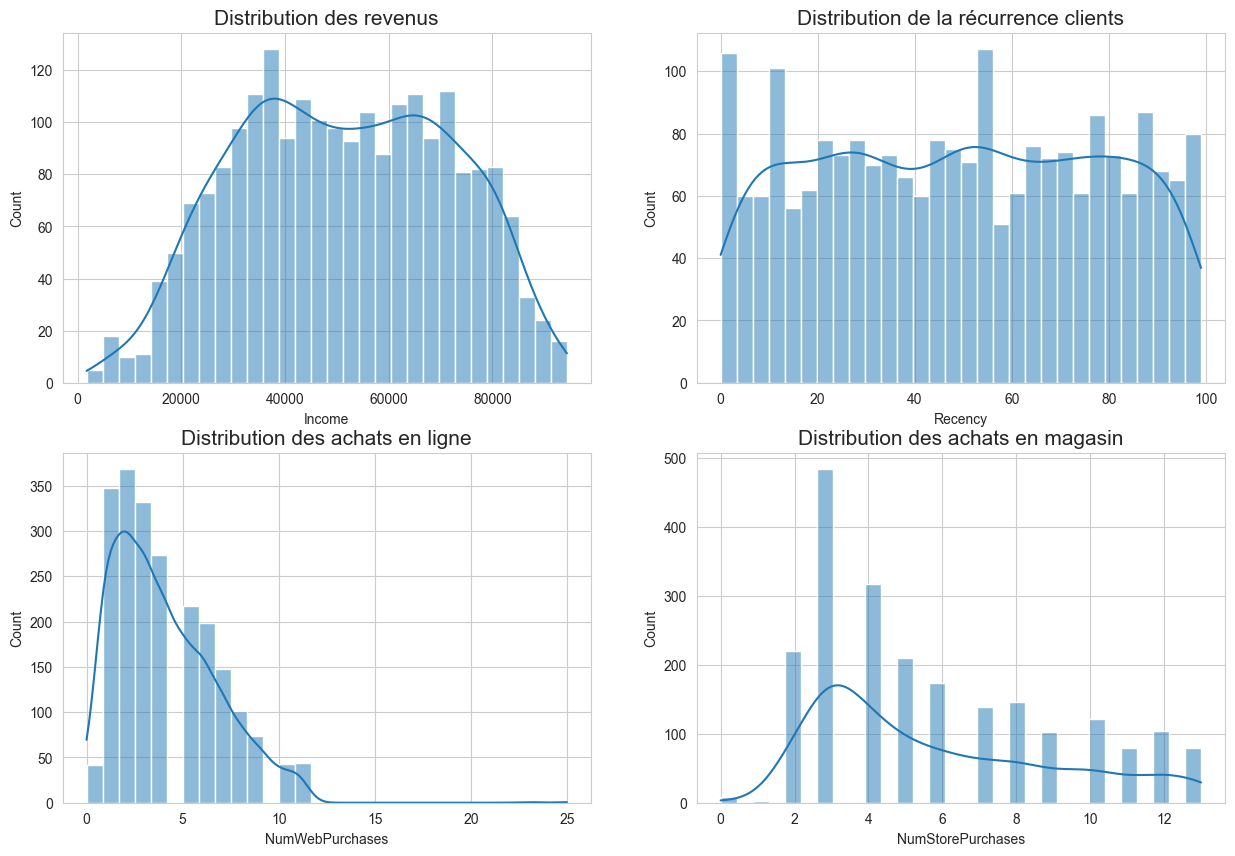

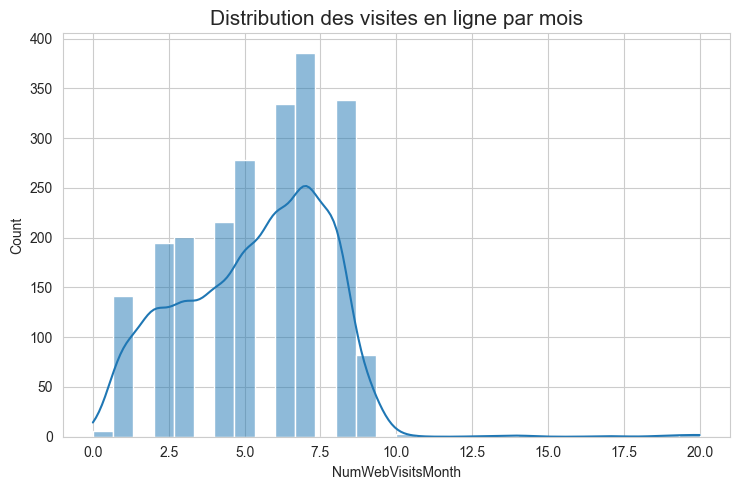

In [90]:
# Code graphiques
sns.set_style("whitegrid")
num_vars = ['Income', 'Recency', 'NumWebPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
titles = ['Distribution des revenus', 'Distribution de la récurrence clients',
          'Distribution des achats en ligne', 'Distribution des achats en magasin', 'Distribution des visites en ligne par mois']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, var, title in zip(axes.flatten(), num_vars[:-1], titles[:-1]):
    sns.histplot(data_encoded[var], bins=30, ax=ax, kde=True)
    ax.set_title(title, fontsize=15)

fig, ax = plt.subplots(figsize=(7.5, 5))
sns.histplot(data_encoded[num_vars[-1]], bins=30, ax=ax, kde=True)
ax.set_title(titles[-1], fontsize=15)
plt.tight_layout()
plt.show()

Concernant les revenus, nous observons une distribution asymétrique positive, avec une concentration de clients dans les tranches de revenu inférieur et quelques clients dans les tranches de revenu supérieur. Il y a également un pic à 0, où nous avons imputé les valeurs manquantes.

Si on se focalise plus sur les achats, des tendances se distinguent :
- En termes de réccurence, on peut voir que la plupart des clients ont effectué un achat relativement récemment, comme le montre le pic sur le côté gauche de la distribution.
- En termes de fréquence d'achat, il est évident que la plupart de nos clients ont effectué un achat relativement récemment, comme le suggère le pic marquant à gauche de la distribution. Cette distribution nous permet de conclure que la majorité de nos clients effectuent jusqu'à 10 achats en ligne, avec un point culminant autour de 5 à 6 achats. En revanche, en ce qui concerne les achats en magasin, ces mêmes clients semblent effectuer entre 2 et 10 achats.

En ce qui concerne les visites mensuelles sur notre site Web, la distribution présente plusieurs pics distincts, suggérant que différents segments de clients visitent notre site avec des fréquences variables.

Maintenant que nous avons étudié les variables numériques, observons la répartition des variables catégorielles comme `Education` et `Marital_Status` :

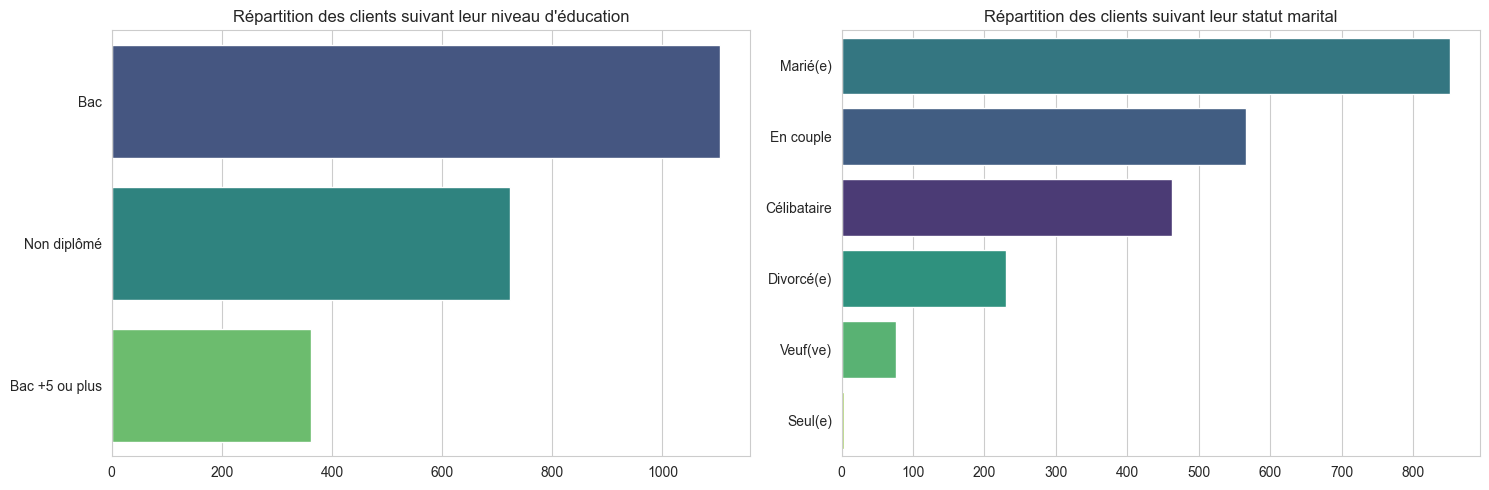

In [79]:
# Mappings
marital_status_mapping = {
    1: "Seul(e)", 2: "Célibataire", 3: "En couple", 4: "Marié(e)", 5: "Divorcé(e)", 6: "Veuf(ve)" }
education_mapping = { 0: "Non diplômé", 1: "Bac", 2: "Bac +5 ou plus" }

data_vis = data_encoded.copy()
data_vis['Marital_Status_Labels'] = data_vis['Marital_Status_Score'].map(marital_status_mapping)
data_vis['Education_Labels'] = data_vis['Education2'].map(education_mapping)

# Code graphiques
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
cat_vars = ['Education_Labels', 'Marital_Status_Labels']
titles = ["Répartition des clients suivant leur niveau d'éducation", "Répartition des clients suivant leur statut marital" ]

for ax, var, title in zip(axes.flatten(), cat_vars, titles):
    sns.countplot(y=data_vis[var], ax=ax, order=data_vis[var].value_counts().index, hue=data_vis[var], palette="viridis")
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

On observe que la plupart de vos clients ont au moins le Baccalauréat, et vivent avec un partenaire. Ce sont des bons indicateurs pour établir le profil de votre client cible.

## B - Analyse bivariée

Maintenant que nous avons vu un peu plus en détails la répartition de votre clientèle et de leurs habitudes de consommation de manière linéaire, ajoutons une dimension en analysant la relation entre la variable cible `Response` et d'autres variables explicatives. Cela nous permettra de déterminer comment la réponse à la campagne est influencée par différentes variables. Nous allons tout d'abord visualiser la proportion de clients qui ont répondu positivement à la campagne par rapport à différentes variables explicatives : 

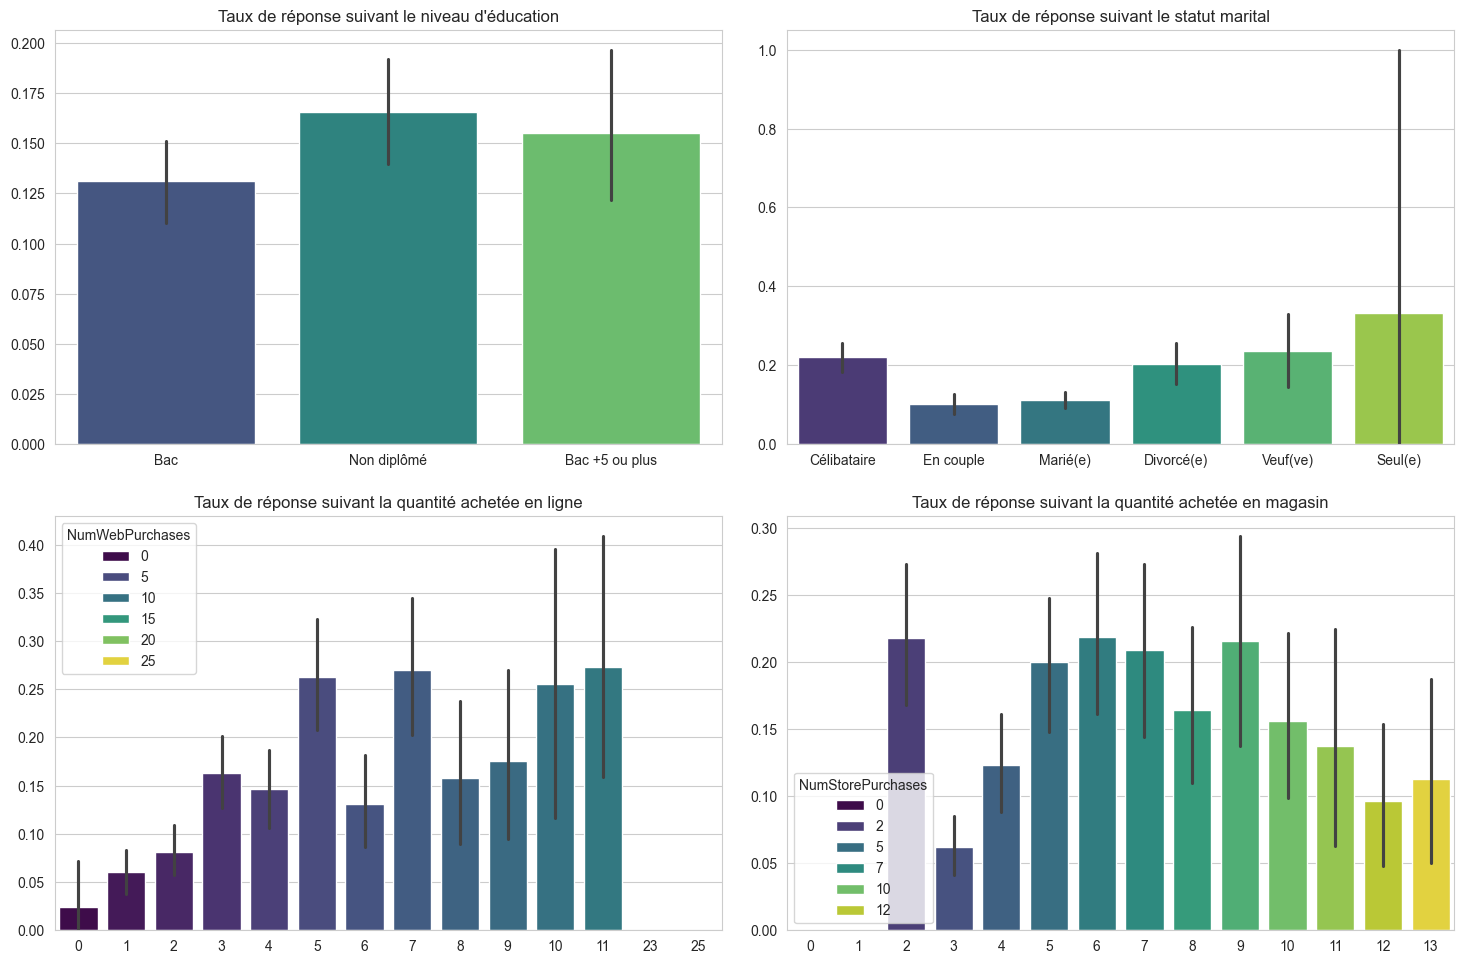

In [95]:
# Code graphiques
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
bi_vars = ['Education_Labels', 'Marital_Status_Labels', 'NumWebPurchases', 'NumStorePurchases']
titles = ["Taux de réponse suivant le niveau d'éducation", "Taux de réponse suivant le statut marital", "Taux de réponse suivant la quantité achetée en ligne", "Taux de réponse suivant la quantité achetée en magasin"]

for ax, var, title in zip(axes.flatten(), bi_vars, titles):
    sns.barplot(x=var, y='Response', data=data_vis, hue=var, ax=ax, palette="viridis")
    ax.set_title(title)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.title.set_position([.5, 1.05])

plt.tight_layout(pad=2.0)
plt.show()

On observe que les clients avec un niveau d'éducation élevé semblent avoir un taux de réponse légèrement supérieur aux autres niveaux d'éducation.
Egalement, les clients divorcés ou célibataires ont également un taux supérieur aux autres catégories. A l'inverse, il semble y avoir une tendance décroissante entre le nombre d'achats effectués en ligne et la réponse à la campagne. Cependant, il est bon de noter qu'il n'y a pas de tendance claire entre le nombre d'achats en magasin et la réponse à la campagne.

### C - Analyse multivariée

Dans le cadre de notre analyse exploratoire, nous avons réalisé une matrice de corrélation pour mettre en lumière des liens entre variables. Ce procédé a pour but d'identifier les variables qui sont fortement corrélées entre elles et avec la variable cible : 

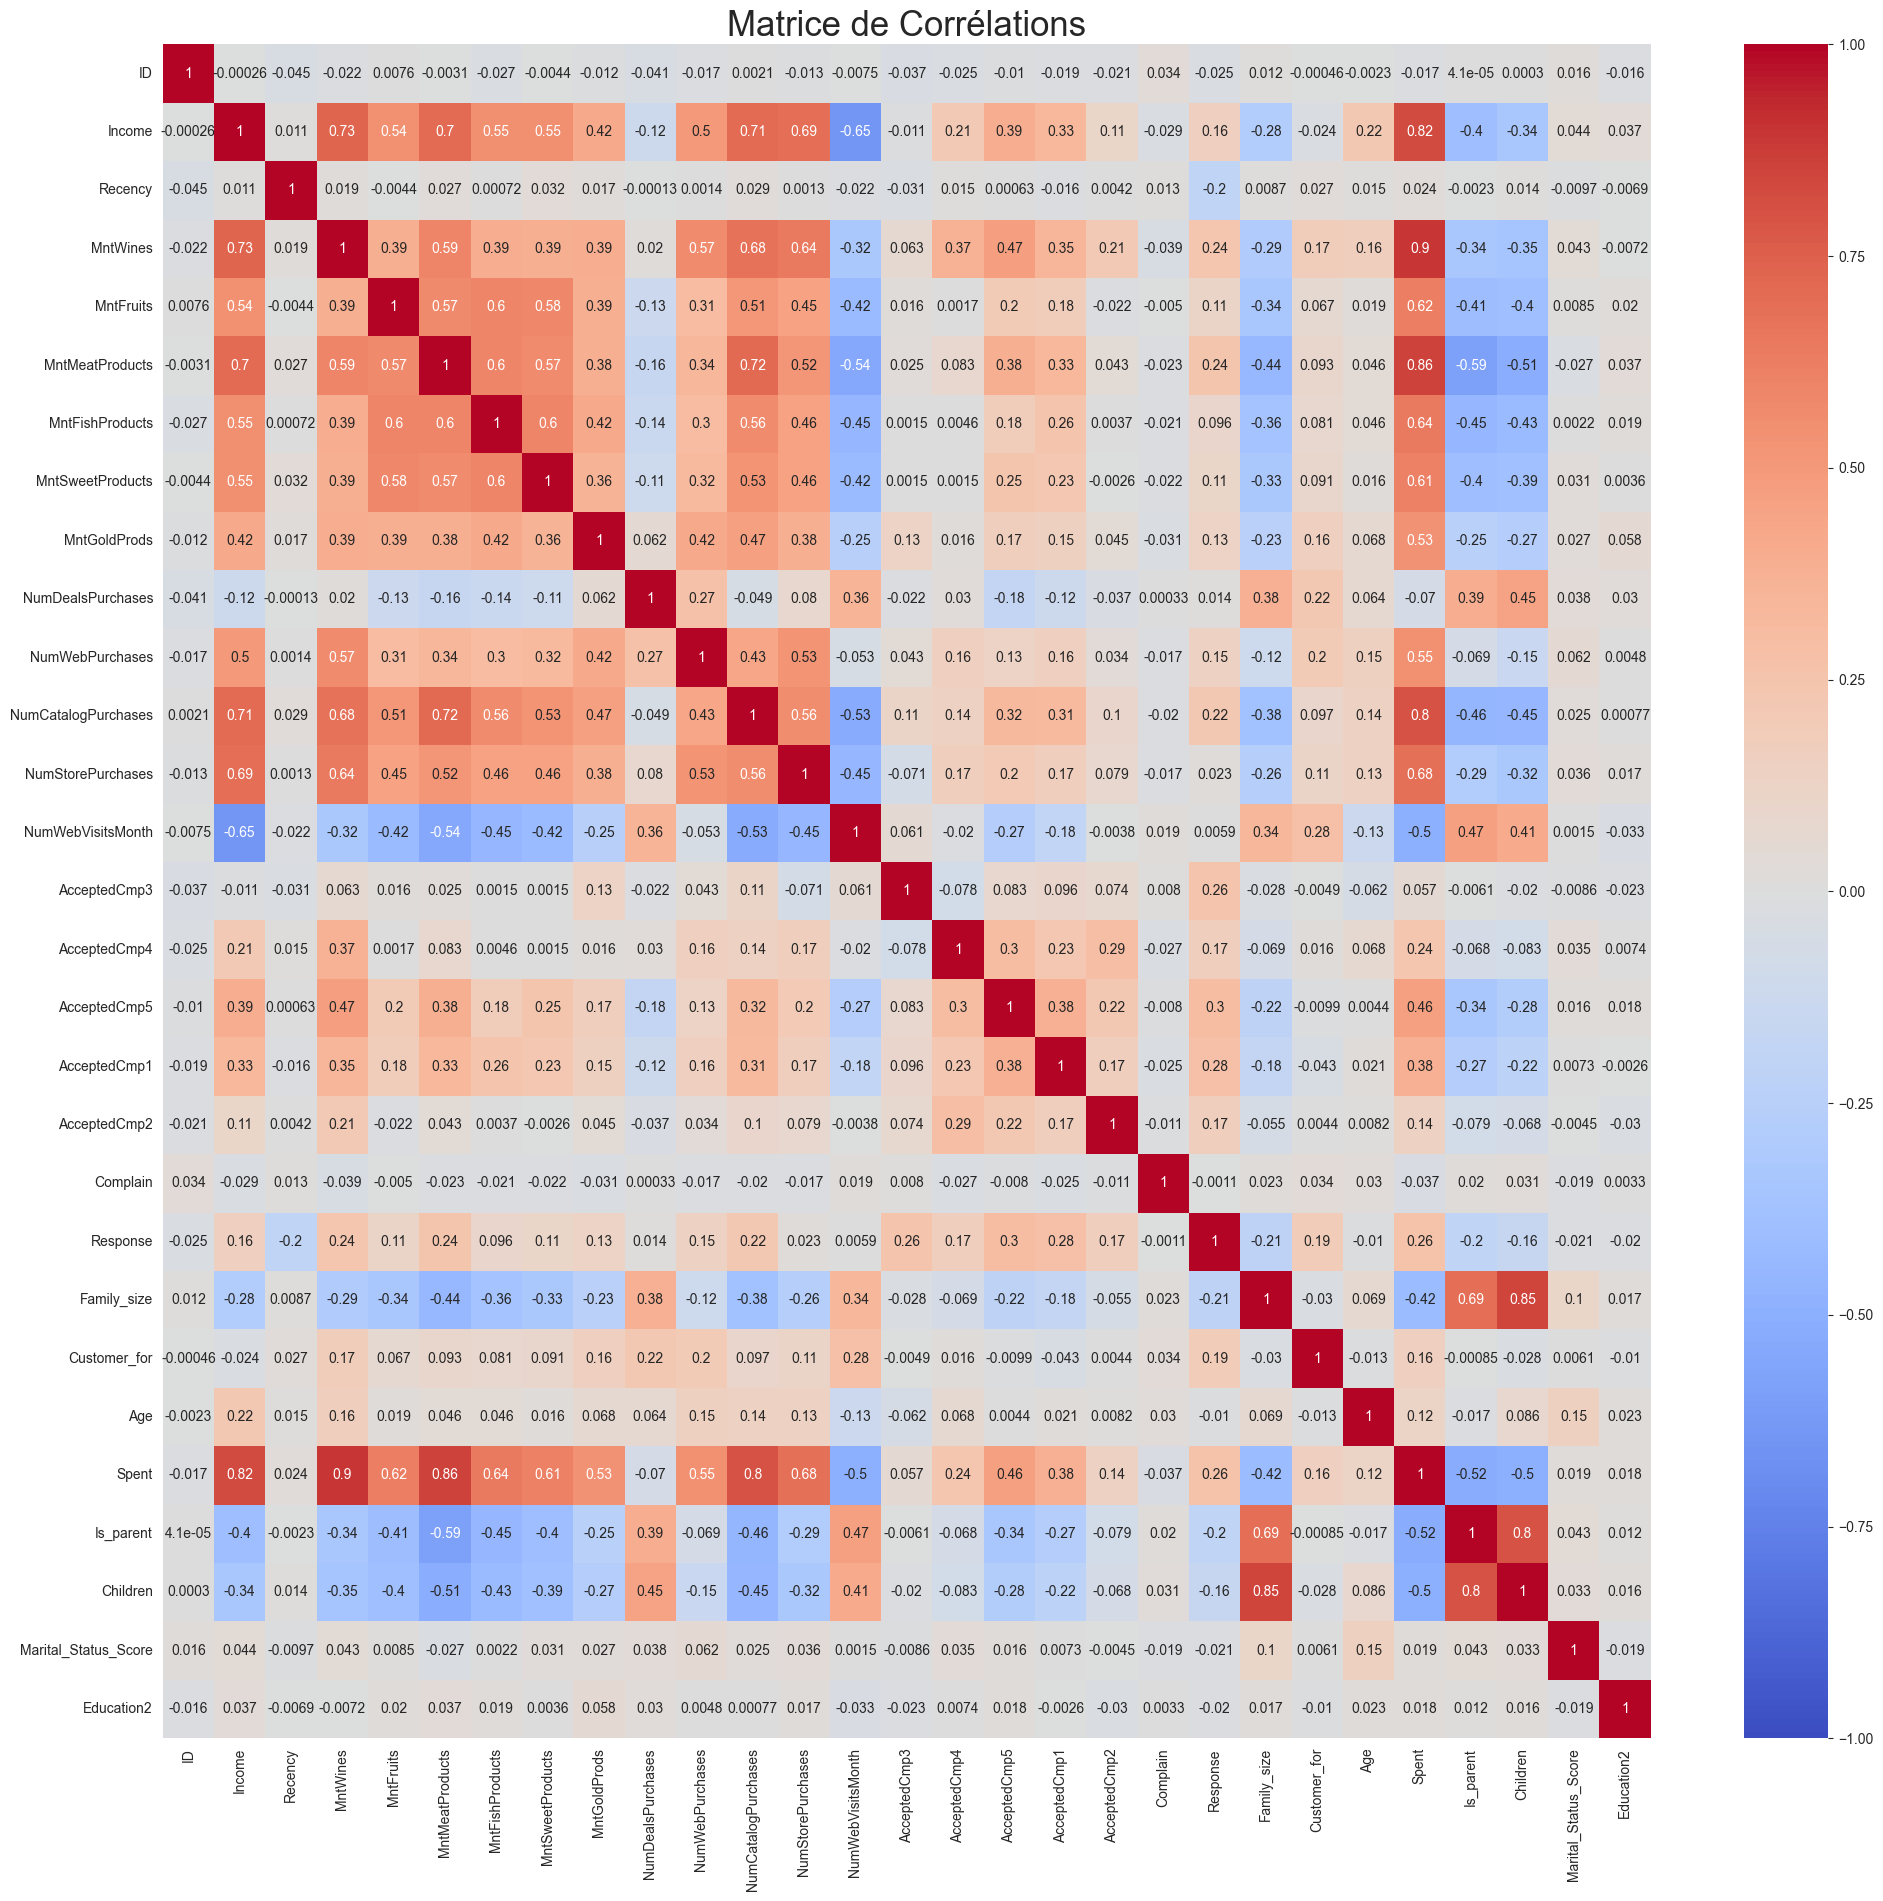

In [81]:
# Code
corr_matrix_encoded = data_encoded.corr()
plt.figure(figsize=(24, 22))
sns.heatmap(corr_matrix_encoded, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrice de Corrélations", fontsize=25)
plt.show()

Nous avons relevé les corrélations positives suivantes :

Naturellement, le montant dépensé et le revenu du client sont étroitement liés. Plus ses revenus sont élevés, plus il va dépenser, et vice-versa. La matrice met également en avant que le montant total de viande achetée par un client a une plus grande proportionnalité avec le montant dépensé. Cela veut dire que plus le montant dépensé sera élevé, plus on a de chances de voir le nombre d’articles de viande être élevé. Cela peut s’expliquer par le fait que la viande fait partie des produits les plus chers. Globalement, nous avons observé que l’achat de viande est plus présent que les autres produits, cela fait partie des habitudes alimentaires des clients.


On observe également que les clients ont tendance à d’avantage acheter de produits depuis le catalogue que par un autre moyen (comme directement au magasin par exemple). Cela est mis à jour par la forte corrélation positive entre le nombre d’achats sur le catalogue et le montant dépensé (0.78). Ainsi, le catalogue utiliserait des moyens entraînant le client à acheter en plus grandes quantités, comme des pratiques marketing visant à augmenter le panier moyen (ex: promotions lors d'achats multiples du même article).

A l'inverse, on relève les corrélations négatives suivantes : 

La corrélation négative entre la taille de la famille et les dépenses (-0.42) met en lumière l'habitude des familles nombreuses à moins dépenser. Plus que moins dépenser, ces dernières font surtout plus attention au prix de leur panier. Ainsi les produit “haut de gamme” sont moins consommés par les familles. Cette théorie est fortement appuyée par la corrélation très négative entre le fait d'être parent et l'achat de viandes (-0.58). Etant donné que la viande fait partie des denrées les plus chères, on peut assumer de cette corrélation que les clients ayant des enfants vont moins dépenser pour acheter de la viande, mais plutôt consacrer leur budget pour d’autres produits. On peut affiner cette hypothèse avec la corrélation positive entre le nombre de visites en ligne par mois et la taille de la famille (0.33). Ils ont tendance à plus regarder les produits sur internet pour prévoir les futures dépenses et bénéficier de promotions.

A l'inverse, on observe une corrélation très négative entre le nombre de visites sur le site et les dépenses (-0,5). Cela veut dire que plus il y a de visites sur le site web, moins il y a de ventes en ligne et en magasin. Cette corrélation négative est aussi observée avec les produits haut de gamme. Nous pouvons en conclure que le site web dissuade les achats, ce qui peut être dû à des photos peu vendeuses sur le site ou un service en ligne qui n'est pas à la hauteur des attentes de la clientèle. Nous pouvons en conclure qu'une refonte du site est nécessaire, et qu’il doit plus mettre en avant les promotions disponibles, de par la corrélation positive (0.35) entre les achats via promotions et les visites sur le site.

# 3 - Analyse par K-Mean 
Les résultats de l'analyse exploratoire nous ont donnés des indications générales sur les tendances de consommation et la répartition de la clientèle. Pour affiner nos résultats et segmenter votre clientèle pour cerner la cible client, nous sommes partis sur une analyse par `K-mean`:

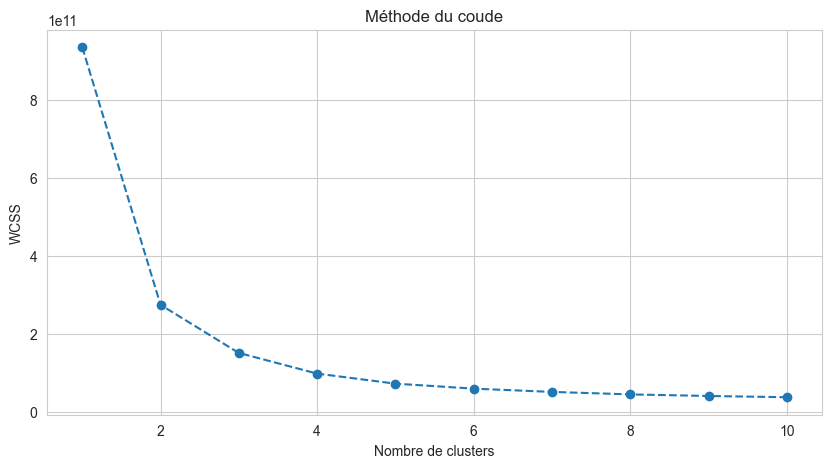

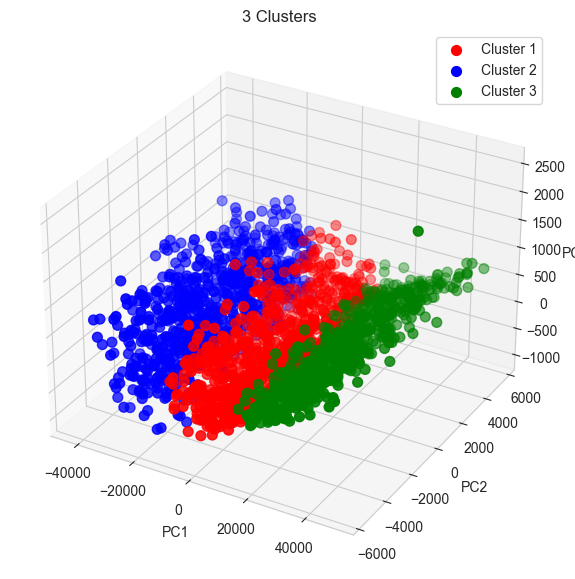

In [87]:
# PCA
pca = PCA(n_components=3)
data_scaled = pca.fit_transform(data_encoded)

# Application de KMeans avec 3 clusters
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)  # Ajout de n_init=10
clusters = kmeans.fit_predict(data_scaled)

# Méthode du coude
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)  # Ajout de n_init=10
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

# Visualisation de la méthode du coude
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')
plt.show()

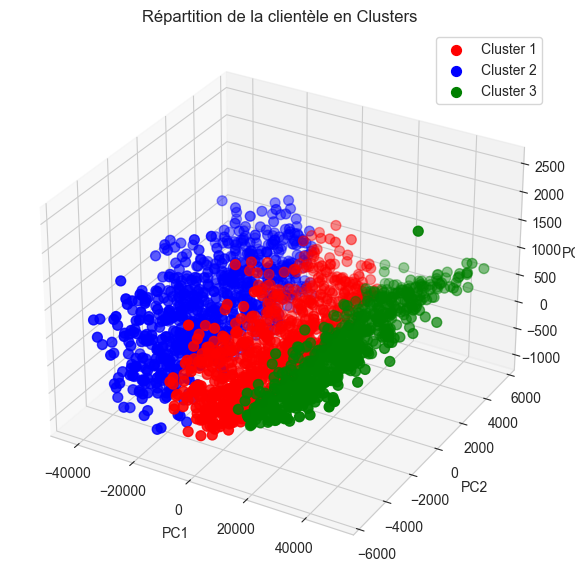

In [89]:
# Visualisation en 3D des clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Assignation des couleurs aux clusters
colors = ['red', 'blue', 'green']
for i in range(3):
    ax.scatter(data_scaled[clusters == i, 0], data_scaled[clusters == i, 1], data_scaled[clusters == i, 2], 
               s=50, color=colors[i], label=f'Cluster {i+1}')

ax.set_title('Répartition de la clientèle en Clusters')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

In [83]:
# Silhouette score
score = silhouette_score(data_scaled, clusters)
print(score)

0.4979415862991675
